Integrating spherical Voronoi code into scipy.spatial will require removing the dependency on pandas, among other things. The purpose of this notebook is to allow interactive testing as I adjust the spherical Voronoi code accordingly and to compare performance / behaviour back to the original code in my own repo.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import scipy
import time
%load_ext autoreload
%autoreload 2
from scipy.spatial import SphericalVoronoi 
import sys; sys.path.append('/Users/treddy/github_projects/py_sphere_Voronoi') #so I can import the code from my own repo for comparison with the scipy-integrated code
import voronoi_utility #my own repo

In [3]:
#generate a random array of 5000 points on the surface of a unit sphere:
prng = numpy.random.RandomState(117) #pin down the random seed
random_coords_on_sphere = voronoi_utility.generate_random_array_spherical_generators(5000, 1.0, prng)

In [4]:
#run the original spherical Voronoi code using the above generators (this should work just fine):
original_voronoi_instance = voronoi_utility.Voronoi_Sphere_Surface(random_coords_on_sphere,1.0)
dictionary_voronoi_polygon_vertices = original_voronoi_instance.voronoi_region_vertices_spherical_surface()

In [5]:
#likewise with the scipy-integrated spherical Voronoi code (this now works after replacing pandas operations with zip() and setdefault dict operations):
scipy_voronoi_instance = SphericalVoronoi(random_coords_on_sphere, 1.0)
scipy_dictionary_voronoi_polygon_vertices = scipy_voronoi_instance.voronoi_region_vertices_spherical_surface()

In [7]:
#given that all unit tests are already passing for the scipy-integrated pandas-free spherical Voronoi code, rather than plotting the spherical Voronoi diagrams to show they are the same, simply show that the dictionaries of polygon vertices match:
common_voronoi_regions = 0
for generator_index, array_polygon_vertices in dictionary_voronoi_polygon_vertices.iteritems():
    scipy_array_polygon_vertices = scipy_dictionary_voronoi_polygon_vertices[generator_index]
    if numpy.all([array_polygon_vertices, scipy_array_polygon_vertices]):
        common_voronoi_regions += 1
    
print 'common_voronoi_regions:', common_voronoi_regions
print 'number of generators:', len(dictionary_voronoi_polygon_vertices.keys())

common_voronoi_regions: 4999
number of generators: 4999


The dictionaries of Voronoi regions match and all unit tests are passing for the scipy-integrated pandas-free code, so we have pretty high confidence in the scipy-migrated code. Now, benchmark the relative performance of the two sets of spherical Voronoi code, to see if I've lost any efficiency by dropping pandas in the scipy version.

In [8]:
array_generator_counts = numpy.array([10,100,1000,5000,10000,15000,20000,25000, 27500, 32000, 40000, 50000, 60000, 70000]) #getting crashes at large numbers of generators
dictionary_spherical_Voronoi_performance_profiles = {}
dictionary_spherical_Voronoi_performance_profiles_scipy_version = {}
prng = numpy.random.RandomState(117)

for generator_count in array_generator_counts:
    current_array_random_generators = voronoi_utility.generate_random_array_spherical_generators(generator_count,1.0,prng)
    
    current_Voronoi_instance = voronoi_utility.Voronoi_Sphere_Surface(current_array_random_generators,1.0)
    current_Voronoi_instance_scipy_version = SphericalVoronoi(current_array_random_generators,1.0)
    
    start_time = time.time()
    dict_generators_and_voronoi_regions = current_Voronoi_instance.voronoi_region_vertices_spherical_surface()
    end_time = time.time()
    time_to_produce_voronoi_regions = end_time - start_time
    
    start_time = time.time()
    dict_generators_and_voronoi_regions_scipy_version = current_Voronoi_instance_scipy_version.voronoi_region_vertices_spherical_surface()
    end_time = time.time()
    time_to_produce_voronoi_regions_scipy_version = end_time - start_time
    
    dictionary_spherical_Voronoi_performance_profiles[generator_count] = {}
    dictionary_spherical_Voronoi_performance_profiles_scipy_version[generator_count] = {}
    dictionary_spherical_Voronoi_performance_profiles[generator_count]['time_to_produce_voronoi_regions'] = time_to_produce_voronoi_regions
    dictionary_spherical_Voronoi_performance_profiles_scipy_version[generator_count]['time_to_produce_voronoi_regions'] = time_to_produce_voronoi_regions_scipy_version
    print 'generator_count:', generator_count, 'processed.'

generator_count: 10 processed.
generator_count: 100 processed.
generator_count: 1000 processed.
generator_count: 5000 processed.
generator_count: 10000 processed.
generator_count: 15000 processed.
generator_count: 20000 processed.
generator_count: 25000 processed.
generator_count: 27500 processed.
generator_count: 32000 processed.
generator_count: 40000 processed.
generator_count: 50000 processed.
generator_count: 60000 processed.
generator_count: 70000 processed.


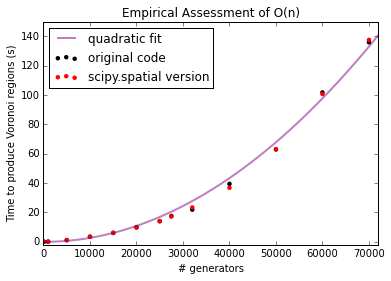

In [9]:
import scipy.optimize
import matplotlib.ticker as mtick
fig_performance = plt.figure()
ax = fig_performance.add_subplot('111')

def quadratic(n, K):
    '''Quadratic fit with K as the constant.'''
    return K * (n ** 2)

y_data = []
y_data_scipy_version = []
for value in array_generator_counts:
    y_data.append(dictionary_spherical_Voronoi_performance_profiles[value]['time_to_produce_voronoi_regions'])
    y_data_scipy_version.append(dictionary_spherical_Voronoi_performance_profiles_scipy_version[value]['time_to_produce_voronoi_regions'])

label = 0 #control legend
for generator_count, subdictionary in dictionary_spherical_Voronoi_performance_profiles.iteritems():
    time_to_produce_Voronoi_regions = subdictionary['time_to_produce_voronoi_regions']
    time_to_produce_Voronoi_regions_scipy_version = dictionary_spherical_Voronoi_performance_profiles_scipy_version[generator_count]['time_to_produce_voronoi_regions']
    if label == 0:
        ax.scatter(generator_count, time_to_produce_Voronoi_regions, edgecolor = 'none', c = 'k', label = 'original code')
        ax.scatter(generator_count, time_to_produce_Voronoi_regions_scipy_version, edgecolor = 'none', c = 'red', label = 'scipy.spatial version')
    else:
        ax.scatter(generator_count, time_to_produce_Voronoi_regions, edgecolor = 'none', c = 'k')
        ax.scatter(generator_count, time_to_produce_Voronoi_regions_scipy_version, edgecolor = 'none', c = 'red')
    label += 1
        
K_quadratic, pcov_quadratic = scipy.optimize.curve_fit(quadratic, array_generator_counts, y_data)
sample_x_data = numpy.linspace(5,72000,num = 50)
#ax.set_xticks([0,20000,40000, 60000])
sample_y_data_quadratic = quadratic(sample_x_data, K_quadratic[0])
ax.plot(sample_x_data, sample_y_data_quadratic, c = 'purple', label = 'quadratic fit', alpha = 0.5, lw = 2)
ax.legend(loc = 2)


ax.set_xlabel('# generators')
ax.set_ylabel('Time to produce Voronoi regions (s)')
ax.set_xlim(-10,72000)
ax.set_ylim(-2,150)
ax.set_title('Empirical Assessment of O(n)')

The scipy-integrated pandas-free version of the code has effectively identical performance over a broad range of generator counts, so at this stage we're pretty confident that the migration of the code was done properly and without detriment to performance.